# Car-mpg

In [460]:
using Plots, PyCall, PyPlot
@pyimport seaborn as sns
@pyimport pandas as pd

## Carmpg dataset

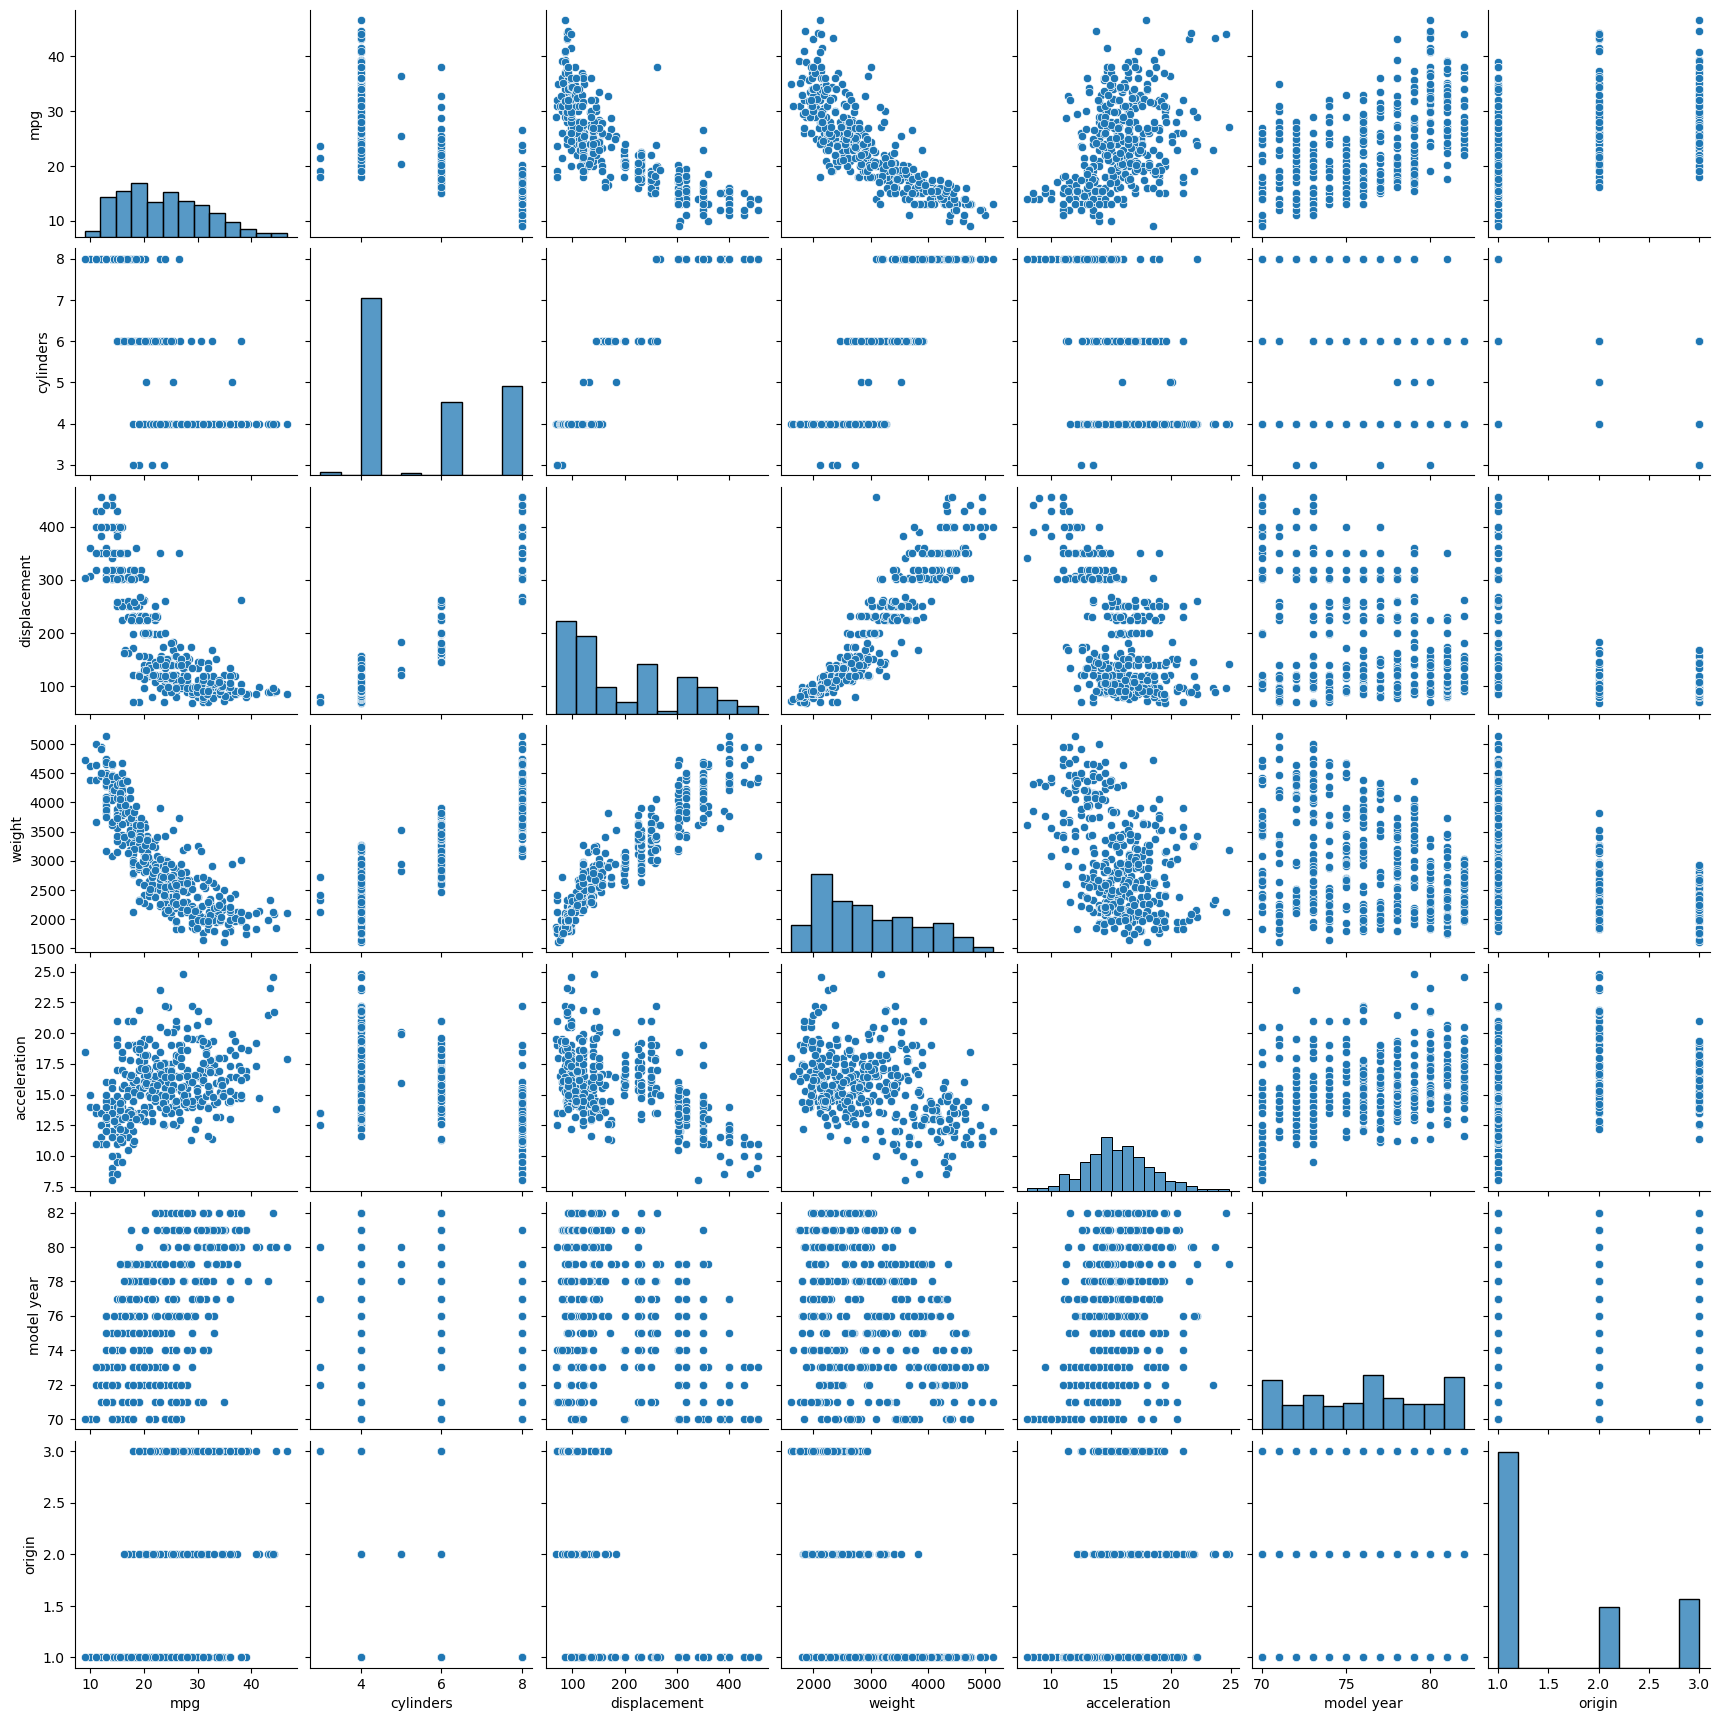

PyObject <seaborn.axisgrid.PairGrid object at 0x7f3e010f9880>

In [302]:
df = pd.read_csv("../Datasets/auto-mpg.csv")
sns.pairplot(df)

## 可以看到，cylinders 和 origin  这两个分类变量对应变量mpg是有影响的，考虑到样本容量只有392，这里将类别较少的 origin 放入模型；

## 连续变量则考虑 displacement, weight, model year, horsepower，

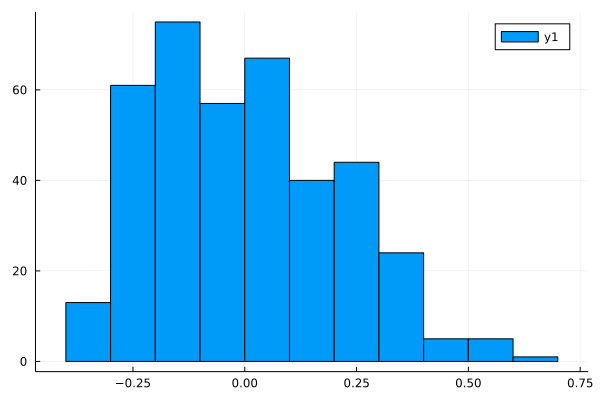

In [734]:
## data pre-process"
include("RealWorldData.ji")

X, Z, y, zmap = get_cardata()
Hy = maximum(y) - minimum(y) 
y = y ./Hy
y = y .- mean(y)

histogram(y)

这里对y进行了放缩，实验中发现如果不这么做离散项的估计就很差；

应该是因为$\gamma$的估计方法，其要求$z$取不同值时, 对应的函数曲线距离不能太大

In [501]:
zmap

1-element Vector{Any}:
 Dict{Any, Any}(2 => [0, 0], 3 => [0, 1], 1 => [1, 0])

origin 的三个不同取值的映射

## PLSIQR fitting

In [801]:

width_exp = -0.2

nfold = 4
index_test, index_train = nsplit_z(Z, nfold)
Alpha = []
Theta = []
Beta = []
Gamma = []
for k in 1:nfold
    indt, indr = index_test[k], index_train[k]
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
    carmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
    qgplsim.estimator(carmodel)
    qgplsim.print_model(carmodel)
    ylx = Xt * carmodel.alpha
    ylz = Zt * carmodel.beta
    gv = qgplsim.predict(carmodel, Xt, Zt)
    yp = (gv + ylx + ylz)
    push!(Alpha, carmodel.alpha)
    push!(Beta, carmodel.beta)
    push!(Theta, carmodel.theta)
    push!(Gamma, carmodel.gamma)
    println("rmse of fold $k: ", rmsd(yp, yt) * Hy, "\n")
end



alpha => [-0.0566, -0.0948, -0.0883, 0.0427]
theta => [0.8916, -0.1632, -0.4196, -0.0487]
gamma => [0.022, 0.0374]
beta => [-0.0173, 0.0149]
rmse of fold 1: 3.955773920681117

alpha => [-0.0364, -0.1017, -0.0488, 0.0493]
theta => [0.9476, -0.2475, -0.2015, -0.0108]
gamma => [0.0798, 0.0153]
beta => [-0.0137, 0.0322]
rmse of fold 2: 3.389029965707862

alpha => [-0.0098, -0.0829, -0.0692, 0.0324]
theta => [0.9634, -0.1707, -0.0274, -0.2049]
gamma => [0.0398, 0.0977]
beta => [0.0066, 0.0185]
rmse of fold 3: 2.931563978496929

alpha => [-0.0216, -0.1051, -0.0077, 0.0402]
theta => [0.9622, -0.2104, -0.1607, -0.0638]
gamma => [-0.0268, 0.0416]
beta => [0.0225, 0.0323]
rmse of fold 4: 3.5229462628404438



In [802]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)
car_model = qgplsim.model(X, Z, y, [0.5], width_exp)
car_model.alpha, car_model.theta, car_model.beta, car_model.gamma = alpha_, theta_, beta_, gamma_ 
ylx = X * car_model.alpha
ylz = Z * car_model.beta
gv = qgplsim.predict(car_model, X, Z)
yp = gv + ylx + ylz  
rmsd(yp, y) * Hy

3.195779666572107

## 单次实验，测试集预测的结果与真实值的对比

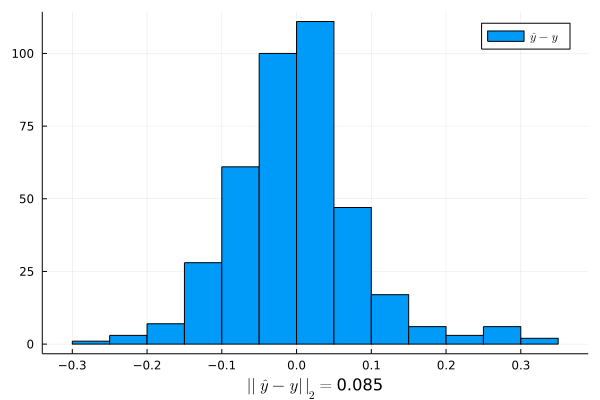

In [803]:
using LaTeXStrings
e = round(rmsd(yp, y), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(y .- yp, label = L"\hat{y} - y")
xlabel!(str)

## 分类变量$z_i$, $i = 1,2,3$， 非参部分估计的在$q = 0.5$时的拟合曲线

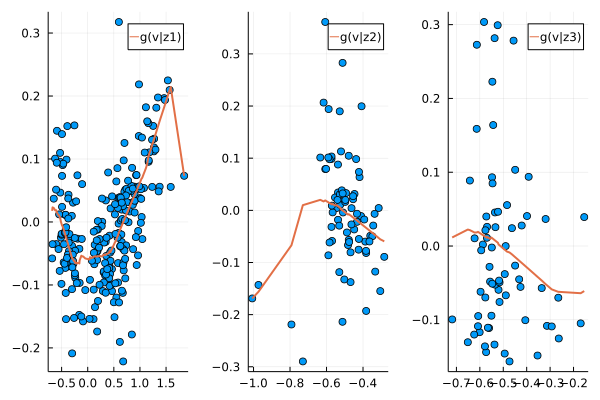

In [804]:
fig = plot(layouts = (1,3))
categ, index = collection(Z)
vv = X * car_model.theta + Z * car_model.gamma
for k in 1:3
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]   
    ypk = gv[indk]   
    ytk = y[indk] - ylx[indk] - ylz[indk]

    sort_ind = sortperm(vk)

    scatter!(pk, vk, ytk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "g(v|z$k)")

end
fig

## Monte Carlo: compared with a semi-mave method from Xia. (2006) 

In [806]:
include("./src/semi_mave.ji")
include("./src/qgplsim.ji")

n_repeat = 25
nfold = 4
Alpha = []
Theta = []
Beta = []
Gamma = []
Theta_mave = []
Beta_mave = []
width_exp = -0.2
@threads for t in 1:4
    for k in 1:n_repeat

        index_test, index_train = nsplit_z(Z, nfold)
        alpha = []
        theta = []
        beta = []
        gamma = []
        θ_mave = []
        β_mave = []
        for k in 1:nfold
            indt, indr = index_test[k], index_train[k]
            Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
            Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
            qr_model = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
            qgplsim.estimator(qr_model)
            push!(alpha, qr_model.alpha)
            push!(beta, qr_model.beta)
            push!(theta, qr_model.theta)
            push!(gamma, qr_model.gamma) 
            
            mave_model = semiMAVE.model(Xr, Zr, yr)
            semiMAVE.estimator(mave_model)         
            push!(β_mave, mave_model.β)
            push!(θ_mave, mave_model.θ)

        end
        alpha_, theta_, beta_, gamma_, beta_mave, theta_mave = mean(alpha), mean(theta), mean(beta), mean(gamma), mean(β_mave), mean(θ_mave)
        push!(Alpha, alpha_)
        push!(Beta, beta_)
        push!(Theta, theta_)
        push!(Gamma, gamma_)

        push!(Beta_mave, beta_mave)
        push!(Theta_mave, theta_mave)

    end
end

┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitq

## 100次蒙特卡洛模拟后各个参数的均值

In [807]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)
[[:alpha, :theta] [mean(Alpha) mean(Theta)]']

2×5 Matrix{Any}:
 :alpha  -0.0363711  -0.0991139  -0.0410121   0.0422382
 :theta   0.913892   -0.292675   -0.06736    -0.0816178

In [808]:
[[:beta, :gamma] [mean(Beta) mean(Gamma)]']

2×3 Matrix{Any}:
 :beta   -8.44518e-5  0.0125158
 :gamma   0.0191303   0.00401637

In [813]:
beta_mave, theta_mave = mean(Beta_mave), mean(Theta_mave)

([-0.39504717576019954, -0.21000187492343173], [-1.0639927543737384, 1.2354935311831072, 0.37420007345938266, -0.6879773681877513])

用这个参数做100次预测

In [816]:
rec_rmsd_qr = []
rec_rmsd_mave = []
@threads for t in 1:4
    for k in 1:n_repeat
    indr, indt = get_train_index(Z, 294)
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr]
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]


    qr_model = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)  
    qr_model.alpha, qr_model.theta, qr_model.beta, qr_model.gamma = alpha_, theta_, beta_, gamma_ 
        
    ylx = Xt * qr_model.alpha
    ylz = Zt * qr_model.beta
    gv = qgplsim.predict(qr_model, Xt, Zt)
    yp_qr = gv + ylx + ylz  
    push!(rec_rmsd_qr, rmsd(yp_qr, yt))
        
    mave_model = semiMAVE.model(Xr, Zr, yr) 
    mave_model.β, mave_model.θ = beta_mave, theta_mave   
        
    gvm, = semiMAVE.predictor(mave_model, Xt, Zt)
    yp_mave = gvm + Zt * mave_model.β
    push!(rec_rmsd_mave, rmsd(yp_mave, yt))        
    end
end

## PLSIQR做100次实验后 $\sqrt{||\hat{y} - y||_2}$的分布

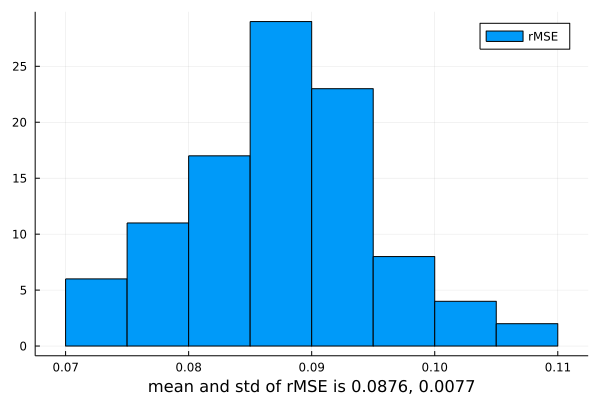

In [817]:
rec_rmsd = rec_rmsd_qr# [ rec_rmsd_qr .< 0.2 ] 
histogram(rec_rmsd, label = "rMSE")
mrmsd = round(mean(rec_rmsd), digits = 4)
std_rmsd = round(std(rec_rmsd), digits = 4)
xlabel!("mean and std of rMSE is $mrmsd, $std_rmsd")

In [818]:
mrmsd * Hy

3.2937600000000002

## SEMI-MAVE做100次实验后 $\sqrt{||\hat{y} - y||_2}$的分布

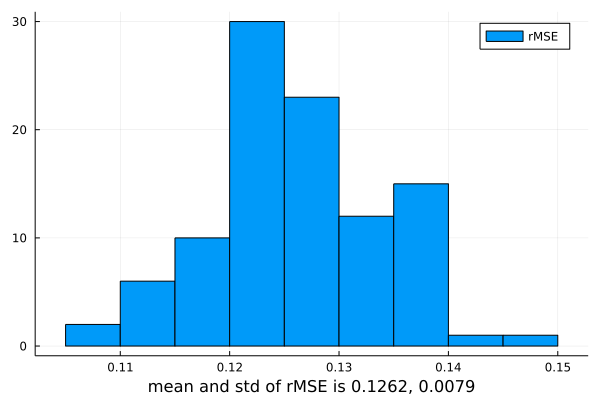

In [819]:
histogram(rec_rmsd_mave, label = "rMSE")
mrmsd_mave = round(mean(rec_rmsd_mave), digits = 4)
std_rmsd_mave = round(std(rec_rmsd_mave), digits = 4)

xlabel!("mean and std of rMSE is $mrmsd_mave, $std_rmsd_mave")

In [820]:
mrmsd_mave * Hy

4.74512

## 总结

夏老师的方法我可能没用调教好，精度太差了，甚至不如线性回归；

单纯就这个数据集来说PLSIQR的精度很好，速度也很快，因为无迭代，即使是qr也比夏老师的快5倍。

#  California Housing

In [1]:
include("./src/supportFunctions.ji")
include("./src/qgplsim.ji")
# include("./src/semi_mave.ji")
include("RealWorldData.ji")
using Plots


In [2]:

Xa, Za, ya = califdata(4.035) # a for all
Z, zmap = categ_binary(Za) # [:, 1]
zmap

2-element Vector{Any}:
 Dict{Any, Any}(2 => [0], 1 => [1])
 Dict{Any, Any}("NEAR BAY" => [1, 0, 0], "INLAND" => [0, 0, 1], "NEAR OCEAN" => [0, 0, 0], "<1H OCEAN" => [0, 1, 0])

## One Single Simulation

In [16]:
X = scaler(Xa, 1)
Hy = maximum(ya) - minimum(ya)
y = ya ./ Hy
y = y .- mean(y)
Z, zmap = categ_binary(Za) # [:, 1]

ntrain = 1000
# 原样本太大，这里选1000个

indr, indt = get_train_index(Z, ntrain)
X, Z, y = X[indr, :], Z[indr, :], y[indr]
# X_rest, Z_rest, y_rest = X[indt, :], Z[indt, :], y[indt]

width_exp = -0.2

nfold = 4

index_test, index_train = nsplit_z(Z, nfold)
Alpha = []
Theta = []
Beta = []
Gamma = []
@threads for k in 1:nfold
    indt, indr = index_test[k], index_train[k]
    Xr, Zr, yr = X[indr, :], Z[indr, :], y[indr] 
    Xt, Zt, yt = X[indt, :], Z[indt, :], y[indt]
    carmodel = qgplsim.model(Xr, Zr, yr, [0.5], width_exp)
    qgplsim.estimator(carmodel)
    # qgplsim.print_model(carmodel)
    ylx = Xt * carmodel.alpha
    ylz = Zt * carmodel.beta
    gv = qgplsim.predict(carmodel, Xt, Zt)
    yp = (gv + ylx + ylz)
    push!(Alpha, carmodel.alpha)
    push!(Beta, carmodel.beta)
    push!(Theta, carmodel.theta)
    push!(Gamma, carmodel.gamma)
    println("rmse of fold $k: ", rmsd(yp, yt), "\n")
end


┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69
┌ Warning: Solution may be non-unique. See http://www.econ.uiuc.edu/~roger/research/rq/FAQ #1/2.
└ @ QuantReg /home/kyan/.julia/packages/QuantReg/8ffaW/src/fitqr.jl:69


rmse of fold 2: 0.15352397842371276

rmse of fold 3: 0.13484266199038722

rmse of fold 1: 0.16235887343828737

rmse of fold 4: 0.14603336370327924



因为 y 被标准化了，这里的rmse可以看作是相对误差

这个精度很一般



In [17]:
alpha_, theta_, beta_, gamma_ = mean(Alpha), mean(Theta), mean(Beta), mean(Gamma)
car_model = qgplsim.model(X, Z, y, [0.5], width_exp)
car_model.alpha, car_model.theta, car_model.beta, car_model.gamma = alpha_, theta_, beta_, gamma_ 
ylx = X * car_model.alpha
ylz = Z * car_model.beta
gv = qgplsim.predict(car_model, X, Z)
yp = gv + ylx + ylz  
rmsd(yp, y) * Hy

71167.6836525345

相当于估计的房价平均差7w多，之前也做过boston的房价预测，也一般

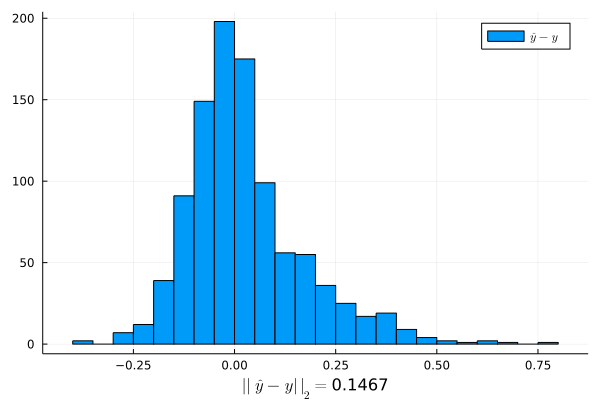

In [18]:
using LaTeXStrings
e = round(rmsd(yp, y), digits = 4)
str = string(L"||\hat{y} - y||_2 = ", "$e")
histogram(y .- yp, label = L"\hat{y} - y")
xlabel!(str)

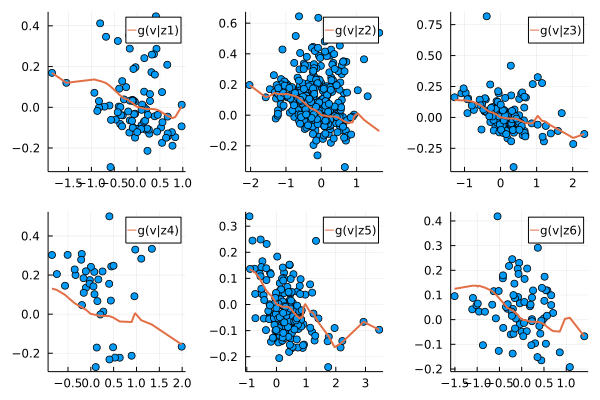

In [19]:
fig = plot(layouts = (2,3))
categ, index = collection(Z)
vv = X*theta_ + Z*gamma_
for k in 1:6
    pk = fig.subplots[k]
    zk = categ[k]
    indk = index[zk]
    
    vk = vv[indk]
    
    ypk = gv[indk]
    
    yk = y[indk] - ylx[indk] - ylz[indk]

    sort_ind = sortperm(vk)

    scatter!(pk, vk, yk, label = false)
    plot!(pk, vk[sort_ind], ypk[sort_ind], width = 2, label = "g(v|z$k)")


end
fig

## 总结


这个数据集样本量太大而且精度不如一些机器学习方法，后面就没做了，后面还是要找适合的数据集。